In [82]:
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
# Cross-sectional GSS data processing
# Load GSS overall data
gss = pd.read_excel("/Users/wooyongjung/WJ_Projects/LLM_POC_Study_2025_v2/data/GSS/GSS.xlsx")

# Create yearid by combining year and id
gss['yearid'] = gss['year'].astype(str) + "_" + gss['id_'].astype(str)

# Expect one row per respondent per wave, columns listed below:
BINARY_ITEMS = ["abdefect","abnomore","abany","abhlth","abpoor","abrape","absingle"]

# Map raw responses → 1/0 (edit as needed to match your GSS coding)
YES_VALUES = {"yes","Yes","YES",1, "1", True}
NO_VALUES  = {"no","No","NO",2, "2", False}

def to_binary(s):
    if pd.isna(s): return np.nan
    return 1 if s in YES_VALUES else (0 if s in NO_VALUES else np.nan)

def prepare_binary(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for col in BINARY_ITEMS:
        if col in out.columns:
            out[col+"_bin"] = out[col].apply(to_binary).astype("float")
    return out

# Following Rossi Scale

def collapse_abortion_attitudes(df: pd.DataFrame, id_col="yearid", binary_items=None):
    """
    Collapse 7 binary GSS abortion items (Rossi Scale) into a single 4-level categorical variable.
    
    - Input: df with columns abdefect ... absingle coded 0/1 (NaN allowed).
    - Output: df with new columns:
        'n_yes'  (count of yes across 7 items)
        'att4'   (collapsed attitude category)
    """
    out = df.copy()

    # Count number of "yes" responses (ignore NaN)
    out["n_yes"] = out[binary_items].sum(axis=1, skipna=True)

    # Count number of non-missing responses
    out["n_nonmiss"] = out[binary_items].notna().sum(axis=1)

    # Map counts into categories
    def map_to_cat(n_yes):
        if pd.isna(n_yes):
            return np.nan
        n_yes = int(n_yes)
        if n_yes <= 1:
            return "strong_anti"
        elif n_yes <= 3:
            return "anti"
        elif n_yes <= 6:
            return "pro"
        else:  # n_yes == 7
            return "strong_pro"

    out["abortion_att4"] = out["n_yes"].apply(map_to_cat)

    return out[[id_col, "year", "n_yes", "n_nonmiss", "abortion_att4"]]


# Construct binary items and collapse into attitude categories
gss_abt_bin = prepare_binary(gss)
gss_abt_bin = collapse_abortion_attitudes(gss_abt_bin, binary_items=[col+"_bin" for col in BINARY_ITEMS])

# Required columns (demographic) from gss_2020
required_columns = ["cohort", "degree", "race", "sex", "polviews", "natenvir", "trust", "wtssps"] # exclude relig, marital (no data for GSS 2024)

# Merge demographic columns
gss_abt_cs = gss_abt_bin.merge(gss[required_columns + ["yearid"]], on="yearid", how="left")

# Create generation column based on birth year
def determine_generation(year):
    if pd.isna(year):
        return None
    elif year.startswith('.'):
        return None
    year = int(year)
    if year <= 1945:
        return "Silent Generation"
    elif 1946 <= year <= 1964:
        return "Baby Boomer"
    elif 1965 <= year <= 1980:
        return "Generation X"
    elif 1981 <= year <= 1996:
        return "Millennial"
    elif 1997 <= year <= 2012:
        return "Generation Z"
    else:
        return "Generation Alpha"

gss_abt_cs['generation'] = gss_abt_cs['cohort'].apply(determine_generation)


# Create education level column
def categorize_education(edu):
    if pd.isna(edu):
        return None
    elif edu in ["Less than high school", "High school"]:
        return "Less or equal to high school"
    elif edu in ["Associate/junior college", "Bachelor's"]:
        return "Associate or Bachelor's Degree"
    elif edu in ["Graduate"]:
        return "Graduate Degree"
    else:
        return None 

gss_abt_cs['edu_level'] = gss_abt_cs['degree'].apply(categorize_education)

# Create gender column
def categorize_gender(gender):
    if pd.isna(gender):
        return None
    elif gender == "MALE":
        return "Male"
    elif gender == "FEMALE":
        return "Female"
    else:
        return "Other"

gss_abt_cs['gender'] = gss_abt_cs['sex'].apply(categorize_gender)

# Create race column
def categorize_race(race):
    if pd.isna(race):
        return None
    elif race == "White":
        return "White"
    elif race == "Black":
        return "Black"
    elif race == "Other":
        return "Other"
    else:
        return None

gss_abt_cs['race'] = gss_abt_cs['race'].apply(categorize_race)

# # Create religion column
# def categorize_religion(relig):
#     if relig in ["Protestant", "Catholic", "None"]:
#         return relig
#     elif pd.isna(relig):
#         return None
#     else:
#         return "Other"

# gss_abt_cs['religion'] = gss_abt_cs['relig'].apply(categorize_religion)

# Create political views column
def categorize_political_views(pv):
    if pd.isna(pv):
        return None
    elif pv in ["Extremely liberal", "Liberal", "Slightly liberal"]:
        return "Liberal"
    elif pv in ["Moderate, middle of the road"]:
        return "Moderate"
    elif pv in ["Slightly conservative", "Conservative", "Extremely conservative"]:
        return "Conservative"
    else:
        return None

gss_abt_cs['political_views'] = gss_abt_cs['polviews'].apply(categorize_political_views)


# Create environmental attitude column
def categorize_environmental_attitude(env):
    if pd.isna(env):
        return None
    if env in ["TOO LITTLE"]:
        return "too_little"
    elif env in ["ABOUT RIGHT"]:
        return "about_right"
    elif env in ["TOO MUCH"]:
        return "too_much"
    else:
        return None
    
gss_abt_cs['natenvir'] = gss_abt_cs['natenvir'].apply(categorize_environmental_attitude)

# Create trust other people column
def categorize_trust(trust):
    if pd.isna(trust):
        return None
    if trust in ["Most people can be trusted"]:
        return "trust"
    elif trust in ["Can't be too careful"]:
        return "distrust"
    elif trust in ["Depends"]:
        return "depends"
    else:
        return None

gss_abt_cs['trust'] = gss_abt_cs['trust'].apply(categorize_trust)

In [84]:
# Panel data processing
# Load panel data (three-wave rollings)
gss_2010 = pd.read_stata('data/GSS/GSS_panel2010w123_R6.dta', convert_categoricals=False)
gss_2008 = pd.read_stata('data/GSS/GSS_panel2008w123_r6 .dta', convert_categoricals=False)
gss_2006 = pd.read_stata('data/GSS/GSS_panel2006w123_r6a.dta', convert_categoricals=False)

# Create a "yearid" column by combining "2010" and index
gss_2010['yearid'] = '2010_' + gss_2010.index.astype(str)
gss_2008['yearid'] = '2008_' + gss_2008.index.astype(str)
gss_2006['yearid'] = '2006_' + gss_2006.index.astype(str)

/var/folders/y6/z9h695vx2w3gbjh7z32h4j9m0000gn/T/ipykernel_50263/2064155114.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gss_2010['yearid'] = '2010_' + gss_2010.index.astype(str)
/var/folders/y6/z9h695vx2w3gbjh7z32h4j9m0000gn/T/ipykernel_50263/2064155114.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gss_2008['yearid'] = '2008_' + gss_2008.index.astype(str)
/var/folders/y6/z9h695vx2w3gbjh7z32h4j9m0000gn/T/ipykernel_50263/2064155114.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

In [85]:
# Panel data processing
# Load panel data (three-wave rollings)
gss_2010 = pd.read_stata('data/GSS/GSS_panel2010w123_R6.dta', convert_categoricals=False)
gss_2008 = pd.read_stata('data/GSS/GSS_panel2008w123_r6 .dta', convert_categoricals=False)
gss_2006 = pd.read_stata('data/GSS/GSS_panel2006w123_r6a.dta', convert_categoricals=False)

# Create a "yearid" column by combining "2010" and index
gss_2010['yearid'] = '2010_' + gss_2010.index.astype(str)
gss_2008['yearid'] = '2008_' + gss_2008.index.astype(str)
gss_2006['yearid'] = '2006_' + gss_2006.index.astype(str)

/var/folders/y6/z9h695vx2w3gbjh7z32h4j9m0000gn/T/ipykernel_50263/2064155114.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gss_2010['yearid'] = '2010_' + gss_2010.index.astype(str)
/var/folders/y6/z9h695vx2w3gbjh7z32h4j9m0000gn/T/ipykernel_50263/2064155114.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gss_2008['yearid'] = '2008_' + gss_2008.index.astype(str)
/var/folders/y6/z9h695vx2w3gbjh7z32h4j9m0000gn/T/ipykernel_50263/2064155114.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

In [86]:
# Panel data processing
# Load panel data (three-wave rollings)
gss_2010 = pd.read_stata('data/GSS/GSS_panel2010w123_R6.dta', convert_categoricals=False)
gss_2008 = pd.read_stata('data/GSS/GSS_panel2008w123_r6 .dta', convert_categoricals=False)
gss_2006 = pd.read_stata('data/GSS/GSS_panel2006w123_r6a.dta', convert_categoricals=False)

# Create a "yearid" column by combining "2010" and index
gss_2010['yearid'] = '2010_' + gss_2010.index.astype(str)
gss_2008['yearid'] = '2008_' + gss_2008.index.astype(str)
gss_2006['yearid'] = '2006_' + gss_2006.index.astype(str)

# Select relevant columns for analysis
required_columns = ["cohort_1", "degree_1", "degree_2", "degree_3", "race_1", "sex_1", "polviews_1", "polviews_2", "polviews_3"]
abortion_items = ["abdefect_1", "abnomore_1", "abany_1", "abhlth_1", "abpoor_1", "abrape_1", "absingle_1",
                 "abdefect_2", "abnomore_2", "abany_2", "abhlth_2", "abpoor_2", "abrape_2", "absingle_2",
                 "abdefect_3", "abnomore_3", "abany_3", "abhlth_3", "abpoor_3", "abrape_3", "absingle_3"]
trust_columns = ["trust_1", "trust_2", "trust_3"]
natenvir_columns = ["natenvir_1", "natenvir_2", "natenvir_3"]

gss_2010 = gss_2010[['yearid'] +required_columns + abortion_items + trust_columns + natenvir_columns]
gss_2008 = gss_2008[['yearid'] + required_columns + abortion_items + trust_columns + natenvir_columns]
gss_2006 = gss_2006[['yearid'] + required_columns + abortion_items + trust_columns + natenvir_columns]

# Rename columns for consistency
gss_2010.rename(columns={"cohort_1": "cohort", "race_1": "race", "sex_1": "gender"}, inplace=True)
gss_2008.rename(columns={"cohort_1": "cohort", "race_1": "race", "sex_1": "gender"}, inplace=True)
gss_2006.rename(columns={"cohort_1": "cohort", "race_1": "race", "sex_1": "gender"}, inplace=True)

/var/folders/y6/z9h695vx2w3gbjh7z32h4j9m0000gn/T/ipykernel_50263/2721443490.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gss_2010['yearid'] = '2010_' + gss_2010.index.astype(str)
/var/folders/y6/z9h695vx2w3gbjh7z32h4j9m0000gn/T/ipykernel_50263/2721443490.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gss_2008['yearid'] = '2008_' + gss_2008.index.astype(str)
/var/folders/y6/z9h695vx2w3gbjh7z32h4j9m0000gn/T/ipykernel_50263/2721443490.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

In [87]:
# Convert dfs to long format: _1 → 2010, _2 → 2012, _3 → 2014
gss_2010_long = pd.wide_to_long(gss_2010, stubnames=['abdefect', 'abnomore', 'abany', 'abhlth', 'abpoor', 'abrape', 'absingle','degree', 'polviews', 'natenvir', 'trust'], 
                                i='yearid', j='wave', suffix='_\\d+').reset_index()
gss_2008_long = pd.wide_to_long(gss_2008, stubnames=['abdefect', 'abnomore', 'abany', 'abhlth', 'abpoor', 'abrape', 'absingle','degree', 'polviews', 'natenvir', 'trust'], 
                                i='yearid', j='wave', suffix='_\\d+').reset_index()
gss_2006_long = pd.wide_to_long(gss_2006, stubnames=['abdefect', 'abnomore', 'abany', 'abhlth', 'abpoor', 'abrape', 'absingle','degree', 'polviews', 'natenvir', 'trust'], 
                                i='yearid', j='wave', suffix='_\\d+').reset_index()

# Create year column based on wave
def map_wave_to_year(wave, base_year):
    if wave == "_1":
        return base_year
    elif wave == "_2":
        return base_year + 2
    elif wave == "_3":
        return base_year + 4
    else:
        return None

gss_2010_long['year'] = gss_2010_long['wave'].apply(lambda w: map_wave_to_year(w, 2010))
gss_2008_long['year'] = gss_2008_long['wave'].apply(lambda w: map_wave_to_year(w, 2008))
gss_2006_long['year'] = gss_2006_long['wave'].apply(lambda w: map_wave_to_year(w, 2006))

In [88]:
# Combine long dfs
gss_abt_panel = pd.concat([gss_2010_long, gss_2008_long, gss_2006_long], ignore_index=True)
gss_abt_panel.shape

(18201, 17)

In [89]:
# Load 2020 panel data
gss_2020 = pd.read_stata('data/GSS/GSS_panel2020_r1a.dta', convert_categoricals=False)

# Expect one row per respondent per wave, columns listed below:
ITEMS_2016 = ["abdefect_1a","abnomore_1a","abany_1a","abhlth_1a","abpoor_1a","abrape_1a","absingle_1a","natenvir_1a","trust_1a"]
ITEMS_2018 = ["abdefect_1b","abnomore_1b","abany_1b","abhlth_1b","abpoor_1b","abrape_1b","absingle_1b","natenvir_1b","trust_1b"]
ITEMS_2020 = ["abdefect_2","abnomore_2","abany_2","abhlth_2","abpoor_2","abrape_2","absingle_2","natenvir_2","trust_2"]

# Split gss_2020 into 2016->2020 and 2018->2020 waves
gss_2016 = gss_2020[gss_2020['samptype'] == 2016]
gss_2018 = gss_2020[gss_2020['samptype'] == 2018]

# Required columns (demographic) from gss_2020
required_columns_2016 = ["cohort_1a", "degree_1a", "race_1a", "gender1_1a", "polviews_1a", "degree_2", "polviews_2"]
required_columns_2018 = ["cohort_1b", "degree_1b", "race_1b", "gender1_1b", "polviews_1b", "degree_2", "polviews_2"]

gss_2016 = gss_2016[['yearid'] + required_columns_2016 + ITEMS_2016 + ITEMS_2020]
gss_2018 = gss_2018[['yearid'] + required_columns_2018 + ITEMS_2018 + ITEMS_2020]

# Rename 1a and 1b
gss_2016.rename(columns={"gender1_1a": "gender", "race_1a": "race", "degree_1a": "degree_1", "cohort_1a": "cohort", "polviews_1a": "polviews_1", "natenvir_1a": "natenvir_1", "trust_1a": "trust_1",
"abdefect_1a": "abdefect_1", "abnomore_1a": "abnomore_1", "abany_1a": "abany_1", "abhlth_1a": "abhlth_1", "abpoor_1a": "abpoor_1", "abrape_1a": "abrape_1", "absingle_1a": "absingle_1"}, inplace=True)
gss_2018.rename(columns={"gender1_1b": "gender", "race_1b": "race", "degree_1b": "degree_1", "cohort_1b": "cohort1", "polviews_1b": "polviews_1", "natenvir_1b": "natenvir_1", "trust_1b": "trust_1",
"abdefect_1b": "abdefect_1", "abnomore_1b": "abnomore_1", "abany_1b": "abany_1", "abhlth_1b": "abhlth_1", "abpoor_1b": "abpoor_1", "abrape_1b": "abrape_1", "absingle_1b": "absingle_1"}, inplace=True)

/var/folders/y6/z9h695vx2w3gbjh7z32h4j9m0000gn/T/ipykernel_50263/1209224429.py:2: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  gss_2020 = pd.read_stata('data/GSS/GSS_panel2020_r1a.dta', convert_categoricals=False)


In [90]:
# Convert to long format for analysis
gss_2016_long = pd.wide_to_long(gss_2016, stubnames=['abdefect', 'abnomore', 'abany', 'abhlth', 'abpoor', 'abrape', 'absingle','degree', 'polviews', 'natenvir', 'trust'], 
                                i='yearid', j='wave', suffix='_\\d+').reset_index()
gss_2018_long = pd.wide_to_long(gss_2018, stubnames=['abdefect', 'abnomore', 'abany', 'abhlth', 'abpoor', 'abrape', 'absingle','degree', 'polviews', 'natenvir', 'trust'],
                                i='yearid', j='wave', suffix='_\\d+').reset_index()

# Create year column based on wave
def map_wave_to_year(wave, last_year, gap):
    if wave == "_1":
        return last_year - gap
    elif wave == "_2":
        return last_year
    else:
        return None

gss_2016_long['year'] = gss_2016_long['wave'].apply(lambda w: map_wave_to_year(w, 2020, 4))
gss_2018_long['year'] = gss_2018_long['wave'].apply(lambda w: map_wave_to_year(w, 2020, 2))


In [91]:
# Combine long dfs
gss_abt_panel = pd.concat([gss_2016_long, gss_2018_long, gss_abt_panel], ignore_index=True)
gss_abt_panel.shape

(28631, 18)

In [92]:
gss_abt_cs['natenvir'].value_counts()

natenvir
too_little     8837
about_right    3423
too_much       1285
Name: count, dtype: int64

In [93]:
gss_abt_cs['trust'].value_counts()

trust
distrust    8789
trust       4329
depends      809
Name: count, dtype: int64

In [94]:
gss_abt_panel['trust'].value_counts()

trust
2.0    9240
1.0    5337
3.0     701
Name: count, dtype: int64

In [95]:
gss_abt_panel['natenvir'].value_counts()

natenvir
1.0    6662
2.0    2959
3.0     890
Name: count, dtype: int64

In [96]:
# Expect one row per respondent per wave, columns listed below:
BINARY_ITEMS = ["abdefect","abnomore","abany","abhlth","abpoor","abrape","absingle"]

# Map raw responses → 1/0 (edit as needed to match your GSS coding)
YES_VALUES = {"yes","Yes","YES",1, "1", True}
NO_VALUES  = {"no","No","NO",2, "2", False}

def to_binary(s):
    if pd.isna(s): return np.nan
    return 1 if s in YES_VALUES else (0 if s in NO_VALUES else np.nan)

def prepare_binary(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for col in BINARY_ITEMS:
        if col in out.columns:
            out[col+"_bin"] = out[col].apply(to_binary).astype("float")
    return out

# Following Rossi Scale

def collapse_abortion_attitudes(df: pd.DataFrame, id_col="yearid", binary_items=None):
    """
    Collapse 7 binary GSS abortion items (Rossi Scale) into a single 4-level categorical variable.
    
    - Input: df with columns abdefect ... absingle coded 0/1 (NaN allowed).
    - Output: df with new columns:
        'n_yes'  (count of yes across 7 items)
        'att4'   (collapsed attitude category)
    """
    out = df.copy()

    # Count number of "yes" responses (ignore NaN)
    out["n_yes"] = out[binary_items].sum(axis=1, skipna=True)

    # Count number of non-missing responses (for reference)
    out["n_nonmiss"] = out[binary_items].notna().sum(axis=1)

    # Map counts into categories
    def map_to_cat(n_yes):
        if pd.isna(n_yes):
            return np.nan
        n_yes = int(n_yes)
        if n_yes <= 1:
            return "strong_anti"
        elif n_yes <= 3:
            return "anti"
        elif n_yes <= 6:
            return "pro"
        else:  # n_yes == 7
            return "strong_pro"

    out["abortion_att4"] = out["n_yes"].apply(map_to_cat)

    return out[[id_col, "year", "n_yes", "n_nonmiss", "abortion_att4", "cohort", "degree", "race", "gender", "polviews", "natenvir", "trust"]]


# Construct binary items and collapse into attitude categories
gss_abt_panel = prepare_binary(gss_abt_panel)
gss_abt_panel = collapse_abortion_attitudes(gss_abt_panel, binary_items=[col+"_bin" for col in BINARY_ITEMS])

In [97]:
# Create generation column based on birth year
def determine_generation(year):
    if pd.isna(year):
        return None
    year = int(year)
    if year <= 1945:
        return "Silent Generation"
    elif 1946 <= year <= 1964:
        return "Baby Boomer"
    elif 1965 <= year <= 1980:
        return "Generation X"
    elif 1981 <= year <= 1996:
        return "Millennial"
    elif 1997 <= year <= 2012:
        return "Generation Z"
    else:
        return "Generation Alpha"
        
gss_abt_panel['generation'] = gss_abt_panel['cohort'].apply(determine_generation)

# Create education level column
def categorize_education(edu):
    if pd.isna(edu):
        return None
    elif edu <= 1:
        return "Less or equal to high school"
    elif edu == 2 or edu == 3:
        return "Associate or Bachelor's Degree"
    elif edu == 4:
        return "Graduate Degree"
    else:
        return None

gss_abt_panel['edu_level'] = gss_abt_panel['degree'].apply(categorize_education)

# Create gender column
def categorize_gender(gender):
    if pd.isna(gender):
        return None
    elif gender == 1:
        return "Male"
    elif gender == 2:
        return "Female"
    else:
        return "Other"

gss_abt_panel['gender'] = gss_abt_panel['gender'].apply(categorize_gender)

# Create race column
def categorize_race(race):
    if pd.isna(race):
        return None
    elif race == 1:
        return "White"
    elif race == 2:
        return "Black"
    elif race == 3:
        return "Other"
    else:
        return "Unknown"

gss_abt_panel['race'] = gss_abt_panel['race'].apply(categorize_race)

# Create political views column
def categorize_political_views(pv):
    if pd.isna(pv):
        return None
    elif pv == 1 or pv == 2 or pv == 3:
        return "Liberal"
    elif pv == 4:
        return "Moderate"
    elif pv == 5 or pv == 6 or pv == 7:
        return "Conservative"
    else:
        return None

gss_abt_panel['political_views'] = gss_abt_panel['polviews'].apply(categorize_political_views)

# Create environmental attitude column
def categorize_environmental_attitude(env):
    if pd.isna(env):
        return None
    if env == 1:
        return "too_little"
    elif env == 2:
        return "about_right"
    elif env == 3:
        return "too_much"
    else:
        return None

gss_abt_panel['natenvir'] = gss_abt_panel['natenvir'].apply(categorize_environmental_attitude)

# Create trust other people column
def categorize_trust(trust):
    if pd.isna(trust):
        return None
    elif trust == 1:
        return "trust"
    elif trust == 2:
        return "distrust"
    elif trust == 3:
        return "depends"
    else:
        return None

gss_abt_panel['trust'] = gss_abt_panel['trust'].apply(categorize_trust)

In [103]:
# # Drop rows with n_nonmiss < 6
gss_abt_cs_abortion = gss_abt_cs[gss_abt_cs['n_nonmiss'] == 7]
gss_abt_panel_abortion = gss_abt_panel[gss_abt_panel['n_nonmiss'] == 7]

# Finally add needed columns and save
gss_abt_cs_abortion[['yearid', 'year', 'generation', 'edu_level', 'gender', 'race', 'political_views', 'natenvir', 'trust', 'abortion_att4', 'wtssps']].to_csv('data/GSS/gss_abt_cs_abortion.csv', index=False)
gss_abt_panel_abortion[['yearid', 'year', 'generation', 'edu_level', 'gender', 'race', 'political_views', 'natenvir', 'trust', 'abortion_att4']].to_csv('data/GSS/gss_abt_panel_abortion.csv', index=False)

gss_abt_cs[['yearid', 'year', 'generation', 'edu_level', 'gender', 'race', 'political_views', 'natenvir', 'trust', 'abortion_att4', 'wtssps']].to_csv('data/GSS/gss_abt_cs_rev.csv', index=False)
gss_abt_panel[['yearid', 'year', 'generation', 'edu_level', 'gender', 'race', 'political_views', 'natenvir', 'trust', 'abortion_att4']].to_csv('data/GSS/gss_abt_panel_rev.csv', index=False)

In [104]:
gss_abt_panel.shape, gss_abt_cs.shape

((28631, 15), (29189, 17))

### Multiple Correspondence Analysis (MCA)

In [101]:
def get_explained_inertia(mca):
    """
    Returns a 1D numpy array of explained inertia per component.
    Works across different prince versions.
    """
    # Newer prince: attribute after fit
    if hasattr(mca, "explained_inertia_") and mca.explained_inertia_ is not None:
        expl = mca.explained_inertia_
        # could be list/np.array/pd.Series
        return np.asarray(expl, dtype=float)

    # Some versions: property w/o underscore
    if hasattr(mca, "explained_inertia") and mca.explained_inertia is not None:
        return np.asarray(mca.explained_inertia, dtype=float)

    # Fallback: compute from eigenvalues_ (typical in multiple FA/CA libs)
    if hasattr(mca, "eigenvalues_") and mca.eigenvalues_ is not None:
        eig = np.asarray(mca.eigenvalues_, dtype=float)
        eig = eig[~np.isnan(eig)]
        tot = eig.sum() if eig.sum() > 0 else 1.0
        return eig / tot

    # Last resort: try private attr (not guaranteed)
    if hasattr(mca, "_eigenvalues"):
        eig = np.asarray(mca._eigenvalues, dtype=float)
        tot = eig.sum() if eig.sum() > 0 else 1.0
        return eig / tot

    # If nothing found, return None
    return None


In [102]:
df = pd.read_csv("data/GSS/gss_abt_cs_rev.csv")
df.head()

,yearid,year,generation,edu_level,gender,race,political_views,natenvir,trust,abortion_att4,wtssps
0,2006_1,2006,Baby Boomer,Less or equal to high school,Female,Black,Liberal,too_little,distrust,anti,0.505483
1,2006_4,2006,Baby Boomer,Less or equal to high school,Female,Black,Liberal,NaN,depends,strong_pro,0.385372
2,2006_5,2006,Millennial,Less or equal to high school,Male,Black,Liberal,NaN,distrust,strong_pro,1.387133
3,2006_9,2006,Millennial,Associate or Bachelor's Degree,Female,Black,Conservative,NaN,distrust,strong_pro,0.421749
4,2006_10,2006,Generation X,Graduate Degree,Female,Other,Liberal,too_little,NaN,strong_pro,0.527395


In [35]:
# MCA Analysis
# Using prince package for MCA
import prince

# Load your cross-sectional GSS data
df = pd.read_csv("data/GSS/gss_abt_cs_rev.csv")

# Select variables of interest
vars_for_mca1 = ["gender", "race", "generation", "edu_level", "political_views", "abortion_att4"]
vars_for_mca2 = ["gender", "race", "generation", "edu_level", "political_views", "natenvir"]
vars_for_mca3 = ["gender", "race", "generation", "edu_level", "political_views", "trust"]
vars_for_mca_all = ["gender", "race", "generation", "edu_level", "political_views", "abortion_att4", "natenvir", "trust"]

# Drop missing values in those columns
df_mca1 = df[vars_for_mca1].dropna()
df_mca2 = df[vars_for_mca2].dropna()
df_mca3 = df[vars_for_mca3].dropna()
df_mca_all = df[vars_for_mca_all].dropna()

# Ensure dtype categorical (helps prince)
for df_mca, vars_for_mca in zip([df_mca1, df_mca2, df_mca3, df_mca_all], [vars_for_mca1, vars_for_mca2, vars_for_mca3, vars_for_mca_all]):
    for c in vars_for_mca:
        df_mca[c] = df_mca[c].astype("category")

Explained inertia (%) — Dim1, Dim2: 53.24%, 46.76%


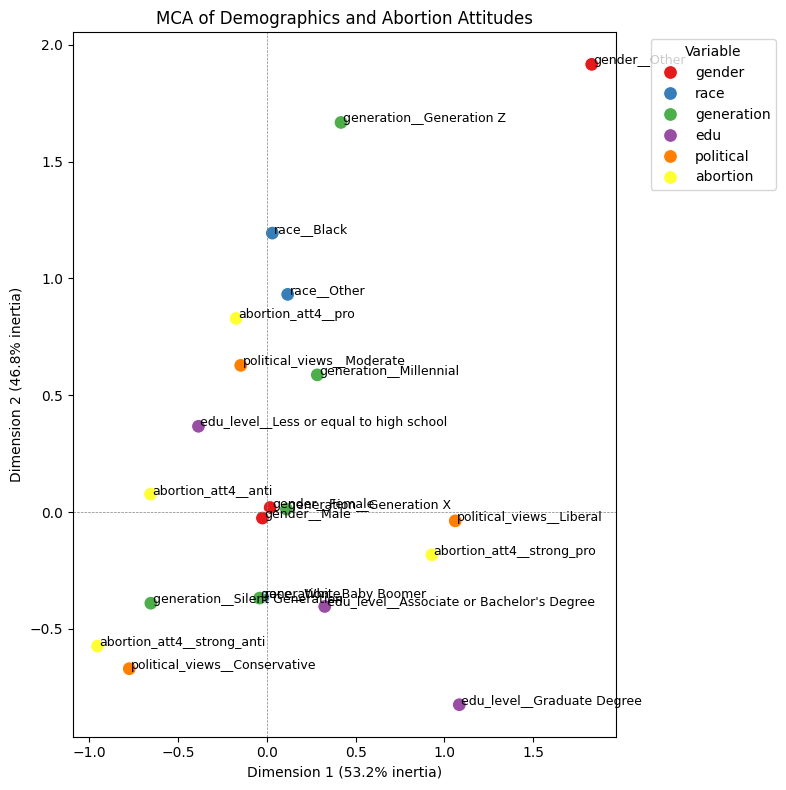

In [39]:
# Fit MCA
mca = prince.MCA(
    n_components=2,
    n_iter=10,
    copy=True,
    check_input=True,
    random_state=42
).fit(df_mca1)

# Row (individual) coordinates
row_coords = mca.transform(df_mca1)

# Column (category) coordinates
col_coords = mca.column_coordinates(df_mca1)  # DataFrame with columns [0, 1] for 2 dims


def get_explained_inertia(mca):
    """
    Returns a 1D numpy array of explained inertia per component.
    Works across different prince versions.
    """
    # Newer prince: attribute after fit
    if hasattr(mca, "explained_inertia_") and mca.explained_inertia_ is not None:
        expl = mca.explained_inertia_
        # could be list/np.array/pd.Series
        return np.asarray(expl, dtype=float)

    # Some versions: property w/o underscore
    if hasattr(mca, "explained_inertia") and mca.explained_inertia is not None:
        return np.asarray(mca.explained_inertia, dtype=float)

    # Fallback: compute from eigenvalues_ (typical in multiple FA/CA libs)
    if hasattr(mca, "eigenvalues_") and mca.eigenvalues_ is not None:
        eig = np.asarray(mca.eigenvalues_, dtype=float)
        eig = eig[~np.isnan(eig)]
        tot = eig.sum() if eig.sum() > 0 else 1.0
        return eig / tot

    # Last resort: try private attr (not guaranteed)
    if hasattr(mca, "_eigenvalues"):
        eig = np.asarray(mca._eigenvalues, dtype=float)
        tot = eig.sum() if eig.sum() > 0 else 1.0
        return eig / tot

    # If nothing found, return None
    return None


# --- Variance explained ---
expl = get_explained_inertia(mca)  # list of length n_components
if expl is None or len(expl) < 2:
    dim1_pct, dim2_pct = 0.0, 0.0
else:
    dim1_pct = expl[0] * 100
    dim2_pct = expl[1] * 100

print("Explained inertia (%) — Dim1, Dim2:", f"{dim1_pct:.2f}%, {dim2_pct:.2f}%")

# --- Plot category points (biplot-style for categories) ---
plt.figure(figsize=(8, 8))
# Color by variable name (prefix before category level)
hues = [idx.split("_")[0] for idx in col_coords.index]  # e.g., 'gender', 'race', 'abortion'
sns.scatterplot(
    x=col_coords[0], y=col_coords[1],
    hue=hues, palette="Set1", s=100, legend="full"
)

for idx, (x, y) in col_coords.iterrows():
    plt.text(x + 0.01, y, idx, fontsize=9)

plt.axhline(0, color="gray", linestyle="--", linewidth=0.5)
plt.axvline(0, color="gray", linestyle="--", linewidth=0.5)
plt.xlabel(f"Dimension 1 ({dim1_pct:.1f}% inertia)")
plt.ylabel(f"Dimension 2 ({dim2_pct:.1f}% inertia)")
plt.title("MCA of Demographics and Abortion Attitudes")
plt.legend(title="Variable", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [41]:
def mca_variable_contributions(df_cat, mca):
    """
    Approximate contributions of variables to each dimension by summing
    squared column coordinates for that variable, weighted by category mass.
    """
    col_coords = mca.column_coordinates(df_cat)  # rows = categories; cols = dims
    col_masses = mca.column_mass_(df_cat) if hasattr(mca, "column_mass_") else None

    # Derive variable name from category index "var_level"
    var_names = [idx.split("_")[0] for idx in col_coords.index]
    contrib = []
    for v in sorted(set(var_names)):
        mask = [vn == v for vn in var_names]
        coords_v = col_coords.loc[np.array(mask)]
        if col_masses is not None:
            masses_v = np.asarray(col_masses.loc[np.array(mask)]).reshape(-1, 1)
            weighted_sq = (coords_v.values ** 2) * masses_v
        else:
            weighted_sq = (coords_v.values ** 2)
        contrib.append((v, weighted_sq.sum(axis=0)))

    contrib_df = pd.DataFrame(
        { "variable": [v for v,_ in contrib],
          "Dim1": [c[0] for _,c in contrib],
          "Dim2": [c[1] for _,c in contrib] }
    )
    # Normalize per-dimension to percentages
    contrib_df["Dim1_pct"] = 100 * contrib_df["Dim1"] / contrib_df["Dim1"].sum()
    contrib_df["Dim2_pct"] = 100 * contrib_df["Dim2"] / contrib_df["Dim2"].sum()
    return contrib_df.sort_values(["Dim1_pct","Dim2_pct"], ascending=False)

# Usage:
df_mca1 = df[vars_for_mca1].dropna().astype("category")
mca = prince.MCA(n_components=2, random_state=42).fit(df_mca1)
contrib_df = mca_variable_contributions(df_mca1, mca)
print(contrib_df)

     variable      Dim1      Dim2   Dim1_pct   Dim2_pct
2      gender  3.350943  3.673521  35.366248  29.639443
0    abortion  2.233234  1.055332  23.569813   8.514842
4   political  1.748443  0.845402  18.453278   6.821043
1         edu  1.430778  0.978103  15.100597   7.891727
3  generation  0.696320  3.414146   7.349042  27.546702
5        race  0.015257  2.427525   0.161023  19.586243


In [42]:
# Fit MCA
mca = prince.MCA(
    n_components=2,
    n_iter=10,
    copy=True,
    check_input=True,
    random_state=42
).fit(df_mca2)

# Row (individual) coordinates
row_coords = mca.transform(df_mca2)

# Column (category) coordinates
col_coords = mca.column_coordinates(df_mca2)  # DataFrame with columns [0, 1] for 2 dims


# --- Variance explained ---
expl = get_explained_inertia(mca)  # list of length n_components
if expl is None or len(expl) < 2:
    dim1_pct, dim2_pct = 0.0, 0.0
else:
    dim1_pct = expl[0] * 100
    dim2_pct = expl[1] * 100

print("Explained inertia (%) — Dim1, Dim2:", f"{dim1_pct:.2f}%, {dim2_pct:.2f}%")

df_mca2 = df[vars_for_mca2].dropna().astype("category")
mca = prince.MCA(n_components=2, random_state=42).fit(df_mca2)
contrib_df = mca_variable_contributions(df_mca2, mca)
print(contrib_df)

Explained inertia (%) — Dim1, Dim2: 53.47%, 46.53%
     variable      Dim1      Dim2   Dim1_pct   Dim2_pct
3    natenvir  3.565746  0.380114  41.855994   3.343078
2  generation  2.336474  6.294295  27.426370  55.357901
4   political  1.489421  0.890023  17.483356   7.827690
5        race  1.038826  1.062219  12.194116   9.342144
1      gender  0.058591  0.010485   0.687768   0.092219
0         edu  0.030021  2.733048   0.352397  24.036968


In [43]:
# Fit MCA
mca = prince.MCA(
    n_components=2,
    n_iter=10,
    copy=True,
    check_input=True,
    random_state=42
).fit(df_mca3)

# Row (individual) coordinates
row_coords = mca.transform(df_mca3)

# Column (category) coordinates
col_coords = mca.column_coordinates(df_mca3)  # DataFrame with columns [0, 1] for 2 dims


# --- Variance explained ---
expl = get_explained_inertia(mca)  # list of length n_components
if expl is None or len(expl) < 2:
    dim1_pct, dim2_pct = 0.0, 0.0
else:
    dim1_pct = expl[0] * 100
    dim2_pct = expl[1] * 100

print("Explained inertia (%) — Dim1, Dim2:", f"{dim1_pct:.2f}%, {dim2_pct:.2f}%")

df_mca3 = df[vars_for_mca3].dropna().astype("category")
mca = prince.MCA(n_components=2, random_state=42).fit(df_mca3)
contrib_df = mca_variable_contributions(df_mca3, mca)
print(contrib_df)

Explained inertia (%) — Dim1, Dim2: 55.86%, 44.14%
     variable      Dim1      Dim2   Dim1_pct   Dim2_pct
2  generation  4.057016  2.371576  42.513565  35.270373
0         edu  2.247925  1.259391  23.556058  18.729817
4        race  1.614407  1.448168  16.917410  21.537345
5       trust  1.301314  0.210456  13.636495   3.129933
3   political  0.307408  1.414480   3.221333  21.036333
1      gender  0.014805  0.019916   0.155139   0.296198


In [44]:
# Fit MCA
mca = prince.MCA(
    n_components=2,
    n_iter=10,
    copy=True,
    check_input=True,
    random_state=42
).fit(df_mca_all)

# Row (individual) coordinates
row_coords = mca.transform(df_mca_all)

# Column (category) coordinates
col_coords = mca.column_coordinates(df_mca_all)  # DataFrame with columns [0, 1] for 2 dims


# --- Variance explained ---
expl = get_explained_inertia(mca)  # list of length n_components
if expl is None or len(expl) < 2:
    dim1_pct, dim2_pct = 0.0, 0.0
else:
    dim1_pct = expl[0] * 100
    dim2_pct = expl[1] * 100

print("Explained inertia (%) — Dim1, Dim2:", f"{dim1_pct:.2f}%, {dim2_pct:.2f}%")

df_mca_all = df[vars_for_mca_all].dropna().astype("category")
mca = prince.MCA(n_components=2, random_state=42).fit(df_mca_all)
contrib_df = mca_variable_contributions(df_mca_all, mca)
print(contrib_df)

Explained inertia (%) — Dim1, Dim2: 52.48%, 47.52%
     variable      Dim1      Dim2   Dim1_pct   Dim2_pct
1         edu  1.954793  0.556723  26.665812   4.463763
0    abortion  1.766300  0.438575  24.094536   3.516461
5   political  1.204584  0.905502  16.432027   7.260253
4    natenvir  0.952430  2.540064  12.992333  20.366057
7       trust  0.706702  0.566670   9.640298   4.543516
3  generation  0.525722  6.140753   7.171509  49.236126
6        race  0.218139  1.310526   2.975688  10.507705
2      gender  0.002038  0.013235   0.027797   0.106119
